In [13]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import string
import re

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
plt.style.use('ggplot')

# Preprocesado y análisis
# ==============================================================================
from scipy import stats
from scipy.stats import pearsonr
import gender_guesser.detector as gender
from sklearn.preprocessing import OneHotEncoder

# Embeddings
# ==============================================================================
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

# Data Cleaning

In [2]:
df = pd.read_excel('../data/raw/basesdedatos.xlsx')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278649 entries, 0 to 278648
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Fecha                        278649 non-null  datetime64[ns]
 1   apat                         278466 non-null  object        
 2   amat                         271958 non-null  object        
 3   nombre                       278633 non-null  object        
 4   tiempo_espera_triage         278579 non-null  float64       
 5   tiempo_en_triage             278579 non-null  float64       
 6   tiempo_espera_despuestriage  277192 non-null  float64       
 7   tiempo_en_consulta           277180 non-null  float64       
 8   clasificacion                278649 non-null  object        
 9   edad                         278649 non-null  int64         
 10  Edad1                        278649 non-null  object        
 11  Dx                        

##### Remove duplicates and null values  

In [4]:
df_without_duplicates = df.drop_duplicates()
df_without_duplicates_and_na = df_without_duplicates.dropna()

length_data = len(df)

print(f"Number of duplicates:\t\t {length_data - len(df_without_duplicates)} - {(length_data - len(df_without_duplicates)) / len(df) * 100:.1f}%")
print(f"Number of missing values:\t {len(df_without_duplicates) - len(df_without_duplicates_and_na)} - {(len(df_without_duplicates) - len(df_without_duplicates_and_na)) / length_data * 100:.1f}%")

Number of duplicates:		 9160 - 3.3%
Number of missing values:	 16227 - 5.8%


##### Convert values to absolute values

In [5]:
df_absolut_values = df_without_duplicates_and_na.copy()
df_absolut_values['tiempo_espera_triage'] = df_without_duplicates_and_na['tiempo_espera_triage'].abs()
df_absolut_values['tiempo_en_triage'] = df_without_duplicates_and_na['tiempo_en_triage'].abs()
df_absolut_values['tiempo_espera_despuestriage'] = df_without_duplicates_and_na['tiempo_espera_despuestriage'].abs()
df_absolut_values['tiempo_en_consulta'] = df_without_duplicates_and_na['tiempo_en_consulta'].abs()
df_absolut_values['edad'] = df_without_duplicates_and_na['edad'].abs()

# create a column with the total time
df_absolut_values['tiempo_total'] = df_absolut_values['tiempo_espera_triage'] + df_absolut_values['tiempo_en_triage'] + df_absolut_values['tiempo_espera_despuestriage'] + df_absolut_values['tiempo_en_consulta']

##### Outliers for 'tiempo_total' (IQR) interquartile range


In [6]:
# Calculate the percentiles
twenty_fifth = df_absolut_values['tiempo_total'].quantile(0.25)
seventy_fifth = df_absolut_values['tiempo_total'].quantile(0.75)

# Obtain IQR
iqr = seventy_fifth - twenty_fifth

# Upper and lower thresholds
upper = seventy_fifth + (1.5 * iqr)
lower = twenty_fifth - (1.5 * iqr)

# Subset the dataset
outliers = df_absolut_values[(df_absolut_values['tiempo_total'] < lower) | (df_absolut_values['tiempo_total'] > upper)]

print(f'Number of outliers:\t {len(outliers)} - {(len(outliers) / length_data * 100):.1f}%')

df_without_outliers = df_absolut_values.drop(outliers.index)

Number of outliers:	 12265 - 4.4%


Text(0.5, 0, 'Total wating time')

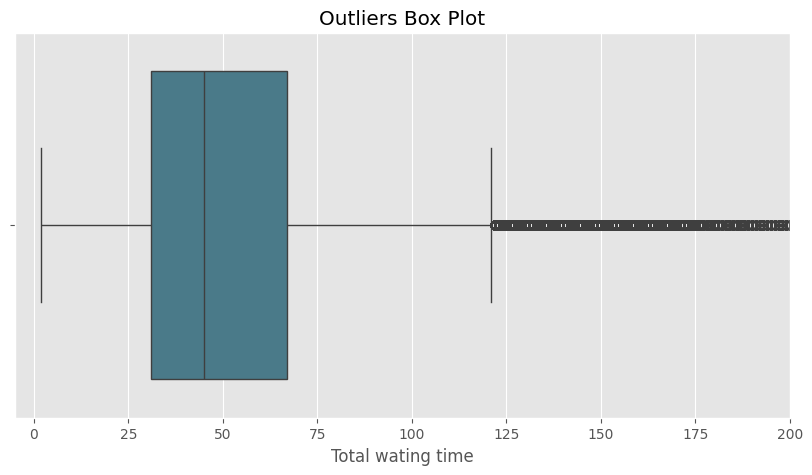

In [7]:
plt.figure(figsize=(10, 5))

# Create a box plot
g = sns.boxplot(data=df_absolut_values, x='tiempo_total', color='#3f7f93')
plt.xlim(-5, 200)

# Add a title and change xlabel
g.set_title('Outliers Box Plot')
g.set_xlabel('Total wating time')

##### Standardize the value of the age

In [8]:
df_cleaning_edad = df_without_outliers.copy()
df_cleaning_edad.rename(columns={'Edad1': 'edad_unidad'}, inplace=True)
# convert column edad_unidad to numeric.
df_cleaning_edad['edad_unidad'] = df_cleaning_edad['edad_unidad'].replace({'Años': 1, 'Meses': 1/12, 'Dias': 1/365})
# standardize the value of the age
df_cleaning_edad['edad'] = df_cleaning_edad['edad'] * df_cleaning_edad['edad_unidad']

/var/folders/4q/13_4dx415y5_msyg7dv7spxr0000gn/T/ipykernel_24236/2472631517.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaning_edad['edad_unidad'] = df_cleaning_edad['edad_unidad'].replace({'Años': 1, 'Meses': 1/12, 'Dias': 1/365})


##### Outliers for 'edad' (IQR)

In [9]:
df_cleaning_edad = df_cleaning_edad.copy()
twenty_fifth = df_cleaning_edad['edad'].quantile(0.25)
seventy_fifth = df_cleaning_edad['edad'].quantile(0.75)

# Obtain IQR
iqr = seventy_fifth - twenty_fifth

# Upper and lower thresholds
upper = seventy_fifth + (1.5 * iqr)
lower = twenty_fifth - (1.5 * iqr)

# Subset the dataset
outliers_edad = df_cleaning_edad[(df_cleaning_edad['edad'] < lower) | (df_cleaning_edad['edad'] > upper)]

print(f'Number of outliers:\t {len(outliers_edad)} - {len(outliers_edad) / length_data * 100:.3f}%')

df_without_outliers_edad = df_cleaning_edad.drop(outliers_edad.index)

Number of outliers:	 3 - 0.001%


Text(0.5, 0, 'Age')

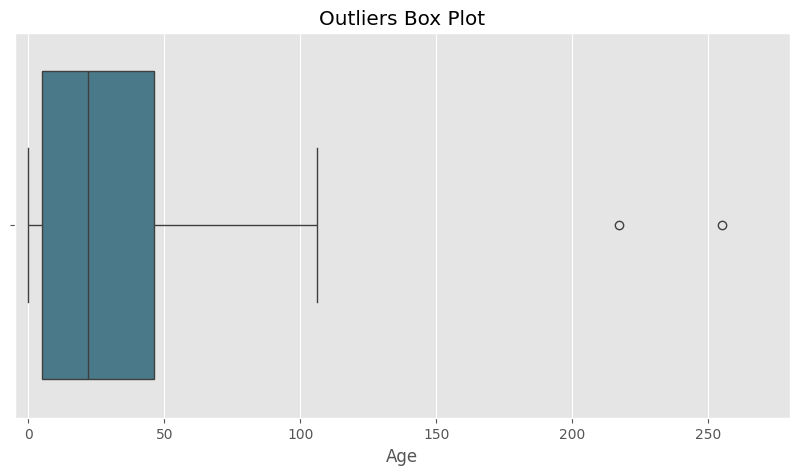

In [10]:
plt.figure(figsize=(10, 5))

# Create a box plot
g = sns.boxplot(data=df_cleaning_edad, x='edad', color='#3f7f93')
plt.xlim(-5, 280)

# Add a title and change xlabel
g.set_title('Outliers Box Plot')
g.set_xlabel('Age')

##### Obtain gender

In [11]:
df_gender_detector = df_without_outliers_edad.copy()

# Create an gender detector object
d = gender.Detector()

def obtener_genero(nombre):
    # setting the second name, there is a total categorization between 'Ambiguo' y 'Desconocido' of 34,535 names
    nombre = nombre.split()[-1]
    nombre = nombre.title()
    # if the name is 'Femenino' or 'Masculino' return the name
    # total categorization between 'Ambiguo' y 'Desconocido' of 27,709 names. Recover 6,826 names
    if nombre == 'Femenino' or nombre == 'Masculino':
        return nombre
    else:
        return d.get_gender(nombre)

df_gender_detector['genero'] = df_gender_detector['nombre'].apply(obtener_genero)

df_gender_detector['genero'] = df_gender_detector['genero'].replace({
    'male': 'Masculino',
    'female': 'Femenino',
    'andy': 'Ambiguo',
    'unknown': 'Desconocido',
    'mostly_male': 'Masculino',
    'mostly_female': 'Femenino'
})

##### Remove 'Ambiguio' and 'Desconocido' values

In [12]:
df_gender_detector_ambiguo = df_gender_detector[(df_gender_detector['genero'] == 'Ambiguo') | (df_gender_detector['genero'] == 'Desconocido')]

print(f'Number of unknown:\t {len(df_gender_detector_ambiguo)} - {len(df_gender_detector_ambiguo) / length_data * 100:.1f}%')

df_gender_detector_clean = df_gender_detector.drop(df_gender_detector_ambiguo.index)

Number of unknown:	 25817 - 9.3%


##### Encode gender and clasification

In [14]:
# Encode calsification of triage
df_encode = df_gender_detector_clean.copy()
# Encode clasification 'ROJO': 0, 'AMARILLO': 1, 'VERDE': 2
df_encode['clasificacion_encode'] = df_encode['clasificacion'].replace({'ROJO': 0, 'AMARILLO': 1, 'VERDE': 2})

encoder = OneHotEncoder(sparse_output=False)
# Aplicar el codificador a la columna 'genero'
genero_encoded = encoder.fit_transform(df_encode[['genero']])
# Convertir la salida a un DataFrame
genero_encoded_df = pd.DataFrame(genero_encoded, columns=encoder.get_feature_names_out(['genero']), index=df_encode.index)
# Concatenar las columnas codificadas con el DataFrame original
df_encode = pd.concat([df_encode, genero_encoded_df], axis=1)

/var/folders/4q/13_4dx415y5_msyg7dv7spxr0000gn/T/ipykernel_24236/2220305101.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_encode['clasificacion_encode'] = df_encode['clasificacion'].replace({'ROJO': 0, 'AMARILLO': 1, 'VERDE': 2})


In [17]:
df_encode.to_csv('../data/interim/data_analisys.csv', index=False)

##### Caracteristics from Date

In [19]:
df_date = df_encode.copy()
# Extract caracteristics from date
df_date['hora'] = df_date['Fecha'].dt.hour
df_date['minuto'] = df_date['Fecha'].dt.minute
df_date['mes'] = df_date['Fecha'].dt.month
df_date['dia'] = df_date['Fecha'].dt.day
df_date['dia_semana'] = df_date['Fecha'].dt.dayofweek

##### Correlation

Text(0, 0.5, 'clasificacion_encode')

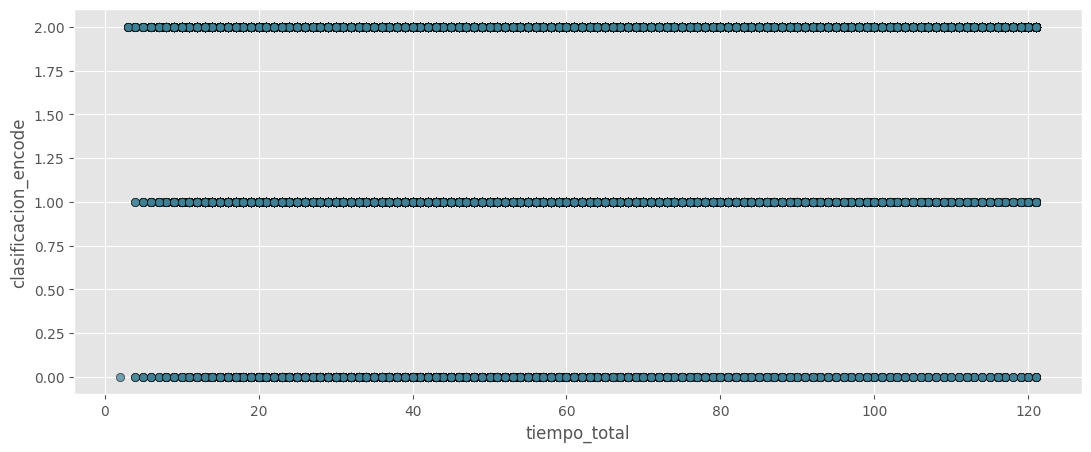

In [20]:
df_corr_graph = df_date.copy()
fig, ax = plt.subplots(1, 1, figsize=(13,5))
ax.scatter(x=df_corr_graph['tiempo_total'], y=df_corr_graph['clasificacion_encode'], alpha=0.7, color='#3f7f93', edgecolor='k')
ax.set_xlabel('tiempo_total')
ax.set_ylabel('clasificacion_encode')

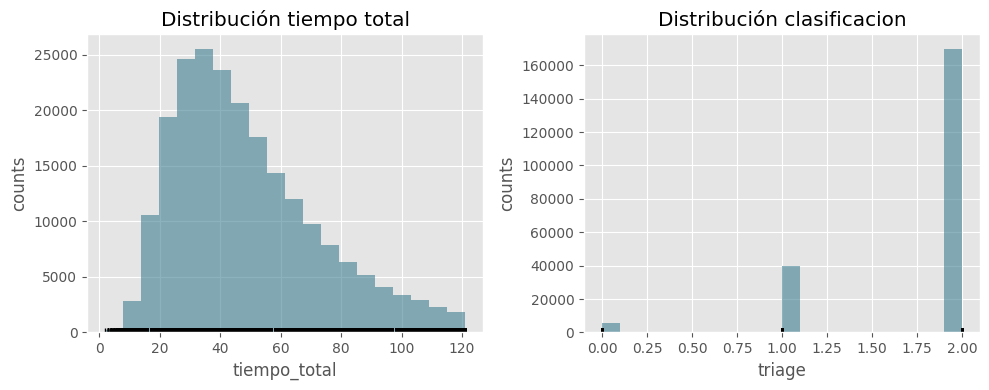

In [21]:
# histogram
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs[0].hist(x=df_corr_graph['tiempo_total'], bins=20, color="#3f7f93", alpha=0.6)
axs[0].plot(df_corr_graph['tiempo_total'], np.full_like(df_corr_graph['tiempo_total'], -0.01), '|k', markeredgewidth=1)
axs[0].set_title('Distribución tiempo total')
axs[0].set_xlabel('tiempo_total')
axs[0].set_ylabel('counts')

axs[1].hist(x=df_corr_graph['clasificacion_encode'], bins=20, color="#3f7f93", alpha=0.6)
axs[1].plot(df_corr_graph['clasificacion_encode'], np.full_like(df_corr_graph['clasificacion_encode'], -0.01), '|k', markeredgewidth=1)
axs[1].set_title('Distribución clasificacion')
axs[1].set_xlabel('triage')
axs[1].set_ylabel('counts')


plt.tight_layout();

In [22]:
df_corr = df_date.copy()
df_corr.drop(columns=['nombre', 'apat', 'amat', 'Fecha', 'Dx', 'edad_unidad', 'genero', 'clasificacion', 'tiempo_espera_triage', 'tiempo_en_triage', 'tiempo_espera_despuestriage', 'tiempo_en_consulta'], inplace=True)
corr = df_corr.corr(method='spearman')

In [23]:
r, p = stats.pearsonr(df_corr['clasificacion_encode'], df_corr['tiempo_total'])
print(f"Correlación Pearson: r={r}, p-value={p}")

r, p = stats.spearmanr(df_corr['clasificacion_encode'], df_corr['tiempo_total'])
print(f"Correlación Spearman: r={r}, p-value={p}")

r, p = stats.kendalltau(df_corr['clasificacion_encode'], df_corr['tiempo_total'])
print(f"Correlación Pearson: r={r}, p-value={p}")

Correlación Pearson: r=0.0788543319531067, p-value=7.8918167265564e-294
Correlación Spearman: r=0.08645255220012005, p-value=0.0
Correlación Pearson: r=0.0703191994468222, p-value=0.0


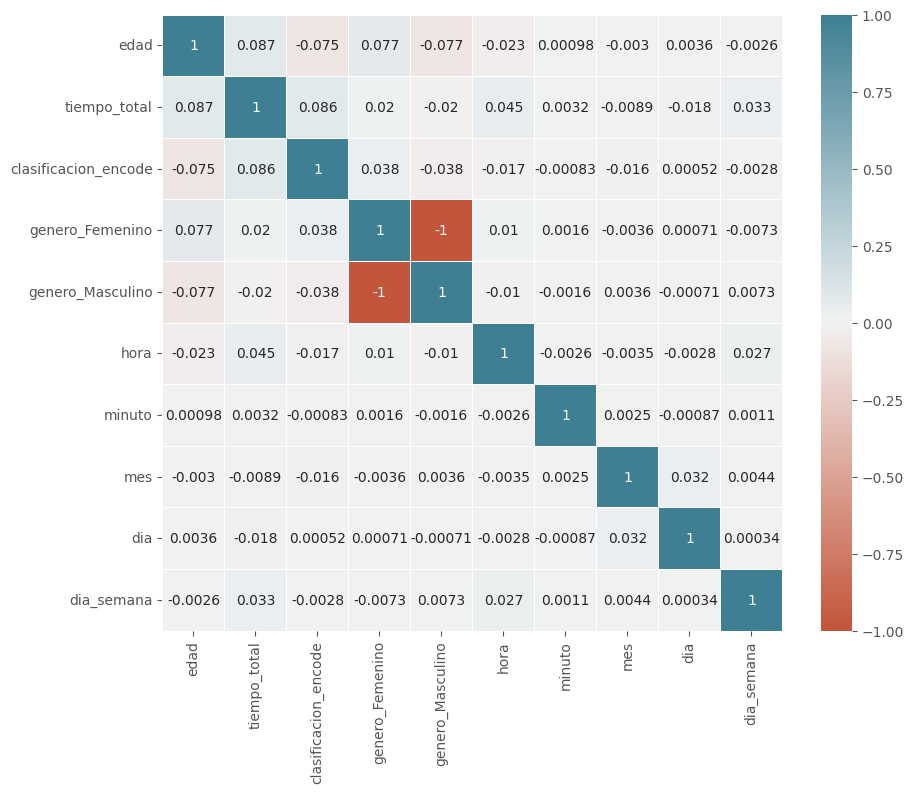

In [24]:
# Crear el mapa de calor
plt.figure(figsize=(10, 8))  # Definir el tamaño de la figura
sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(20, 220, n=200), linewidths=0.5)

# Mostrar el gráfico
plt.show()

##### Removal of Punctuations

In [25]:
df_clean_text = df_date.copy()

In [26]:
# clean text
df_not_string = df_clean_text[~df_clean_text['Dx'].apply(lambda x: isinstance(x, str))]
print(f'Number of not string values:\t {len(df_not_string)} - {len(df_not_string) / length_data * 100:.3f}%')
df_clean_text = df_clean_text.drop(df_not_string.index)

def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', string.punctuation + '1' + '2' + '3'))

df_clean_text['Dx'] = df_clean_text['Dx'].apply(lambda text: remove_punctuation(text))

Number of not string values:	 6 - 0.002%


##### Remove empty string

In [27]:
df_empty_string = df_clean_text[df_clean_text['Dx'] == '']
print(f'Number of empty string:\t {len(df_empty_string)} - {len(df_empty_string) / length_data * 100:.1f}%')

df_without_empty_str = df_clean_text.drop(df_empty_string.index)

Number of empty string:	 1171 - 0.4%


##### Lower casing

In [28]:
df_lower_casing = df_without_empty_str.copy()
df_lower_casing['Dx'] = df_lower_casing['Dx'].str.lower()

##### Delete meaningless strings

In [29]:
meaningless_strings = df_lower_casing.copy()

def search_meaningless_str(text):
    found = re.search("^x+$", text)
    if found is not None:
        return True
    else:
        return False

df_x_strings = meaningless_strings[meaningless_strings['Dx'].apply(search_meaningless_str)]
print(f'Number of meaningless string:\t {len(df_x_strings)} - {len(df_x_strings) / length_data * 100:.1f}%')

df_deleted_meaningless = meaningless_strings.drop(df_x_strings.index)


Number of meaningless string:	 274 - 0.1%


##### Embeddings

In [30]:
df_regresion = df_without_empty_str.copy()

In [31]:
# Create a TaggedDocument object
tagged_data = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(df_regresion['Dx'])]

# Create a Doc2Vec model
model = Doc2Vec(vector_size=100, window=2, min_count=1, workers=4)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=40)

df_regresion['doc2vec'] = [model.dv[str(i)] for i in range(len(tagged_data))]

df_doc2vec = pd.DataFrame(df_regresion['doc2vec'].tolist(), index=df_regresion.index)
df_cleaned = pd.concat([df_regresion.drop('doc2vec', axis=1), df_doc2vec], axis=1)

##### Save Data in CSV

In [32]:
# EDIESCA data needed
df_ediesca = df_date.drop(columns=['nombre', 'apat', 'amat', 'Fecha', 'Dx', 'edad_unidad', 'genero', 'clasificacion'])
print(df_ediesca.shape)
# ARTICLE data needed
df_article = df_cleaned.drop(columns=['nombre', 'apat', 'amat', 'Fecha', 'Dx', 'edad_unidad', 'genero', 'clasificacion', 'tiempo_espera_triage', 'tiempo_en_triage', 'tiempo_espera_despuestriage', 'tiempo_en_consulta'])
print(df_article.shape)

(215177, 14)
(214000, 110)


In [33]:
# convert to csv file
df_ediesca.to_csv('../data/processed/EDIESCA.csv', index=False)
df_article.to_csv('../data/processed/ARTICLE.csv', index=False)